# Probabilistic program synthesis for tabular data using CrossCat+CGPM

<img src="resources/bayesian-program-synthesis.jpg"/>

In [1]:
import numpy as np
import pandas as pd

In [2]:
prng = np.random.RandomState(10)

#### Prepare the population schema.

In [3]:
schema = [
    ('categorical', {'k': 79}),  # 0 Country_of_Operator
    ('categorical', {'k': 346}), # 1 Operator_Owner
    ('categorical', {'k': 18}),  # 2 Users
    ('categorical', {'k': 46}),  # 3 Purpose
    ('categorical', {'k': 4}),   # 4 Class_of_Orbit
    ('categorical', {'k': 7}),   # 5 Type_of_Orbit
    ('normal', None),            # 6 Perigee_km
    ('normal', None),            # 7 Apogee_km
    ('normal', None),            # 8 Eccentricity
    ('normal', None),            # 9 Period_minutes
    ('normal', None),            # 10 Launch_Mass_kg
    ('normal', None),            # 11 Dry_Mass_kg
    ('normal', None),            # 12 Power_watts
    ('normal', None),            # 13 Date_of_Launch
    ('normal', None),            # 14 Anticipated_Lifetime
    ('categorical', {'k': 282}), # 15 Contractor
    ('categorical', {'k': 54}),  # 16 Country_of_Contractor
    ('categorical', {'k': 25}),  # 17 Launch_Site
    ('categorical', {'k': 141}), # 18 Launch_Vehicle
    ('categorical', {'k': 38}),  # 19 Source_Used_for_Orbital_Data
    ('normal', None),            # 20 longitude_radians_of_geo
    ('normal', None),            # 21 Inclination_radians
]

#### Sample an AST from the prior.

In [4]:
from cgpm2 import sample_crosscat

In [5]:
ast = sample_crosscat.generate_random_ast(schema, prng)

In [6]:
ast

[((100000, ('crp', None), {'alpha': 1.121268}),
  [(0, ('categorical', {'k': 79}), {'alpha': 0.719775}),
   (8,
    ('normal', None),
    {'m': 1.710845, 'nu': 0.433329, 'r': 0.221829, 's': 1.943864}),
   (11,
    ('normal', None),
    {'m': 0.163875, 'nu': 4.392115, 'r': 0.484694, 's': 2.88707})]),
 ((100001, ('crp', None), {'alpha': 0.583097}),
  [(1, ('categorical', {'k': 346}), {'alpha': 1.050958}),
   (4, ('categorical', {'k': 4}), {'alpha': 0.737407}),
   (5, ('categorical', {'k': 7}), {'alpha': 2.393045}),
   (7,
    ('normal', None),
    {'m': 1.76423, 'nu': 0.793158, 'r': 0.048032, 's': 0.984268}),
   (12,
    ('normal', None),
    {'m': 0.609366, 'nu': 0.909741, 'r': 1.749406, 's': 0.289516}),
   (16, ('categorical', {'k': 54}), {'alpha': 0.04078}),
   (20,
    ('normal', None),
    {'m': 0.425179, 'nu': 1.440711, 'r': 0.044054, 's': 2.119557}),
   (21,
    ('normal', None),
    {'m': 2.104527, 'nu': 0.72045, 'r': 0.540442, 's': 0.930333})]),
 ((100002, ('crp', None), {'alpha

#### Compile the AST into the "Core DSL".

In [7]:
core_dsl = sample_crosscat.compile_ast_to_core_dsl(ast)

In [8]:
print core_dsl.getvalue()

- view:
    row clustering model:
      - crp{id:100000}:
          distargs:
          hypers:
            alpha: 1.1213
    distribution models:
      - categorical{id:0}:
          distargs:
            k: 79
          hypers:
            alpha: 0.7198
      - normal{id:8}:
          distargs:
          hypers:
            s: 1.9439
            r: 0.2218
            m: 1.7108
            nu: 0.4333
      - normal{id:11}:
          distargs:
          hypers:
            s: 2.8871
            r: 0.4847
            m: 0.1639
            nu: 4.3921
- view:
    row clustering model:
      - crp{id:100001}:
          distargs:
          hypers:
            alpha: 0.5831
    distribution models:
      - categorical{id:1}:
          distargs:
            k: 346
          hypers:
            alpha: 1.0510
      - categorical{id:4}:
          distargs:
            k: 4
          hypers:
            alpha: 0.7374
      - categorical{id:5}:
          distargs:
            k: 7
          hypers

#### Compile "Core DSL" into the "Embedded DSL".

In [9]:
embedded_dsl = sample_crosscat.compile_core_dsl_to_embedded_dsl(core_dsl.getvalue())

In [10]:
print embedded_dsl.getvalue()

from cgpm2.categorical import Categorical
from cgpm2.crp import CRP
from cgpm2.flexible_rowmix import FlexibleRowMixture
from cgpm2.normal import Normal
from cgpm2.poisson import Poisson
from cgpm2.product import Product

nan = float('nan')

view0 = FlexibleRowMixture(
  cgpm_row_divide=CRP(outputs=[100000], inputs=[], hypers={'alpha': 1.1213},),
  cgpm_components_base=Product(cgpms=[
    Categorical(outputs=[0], inputs=[], distargs={'k': 79}, hypers={'alpha': 0.7198},),
    Normal(outputs=[8], inputs=[], hypers={'s': 1.9439, 'r': 0.2218, 'm': 1.7108, 'nu': 0.4333},),
    Normal(outputs=[11], inputs=[], hypers={'s': 2.8871, 'r': 0.4847, 'm': 0.1639, 'nu': 4.3921},),])
)
view1 = FlexibleRowMixture(
  cgpm_row_divide=CRP(outputs=[100001], inputs=[], hypers={'alpha': 0.5831},),
  cgpm_components_base=Product(cgpms=[
    Categorical(outputs=[1], inputs=[], distargs={'k': 346}, hypers={'alpha': 1.051},),
    Categorical(outputs=[4], inputs=[], distargs={'k': 4}, hypers={'alpha': 0.7374},),


#### Execute the Embeddd DSL source code to build the model trace.

In [11]:
exec(embedded_dsl.getvalue())

In [12]:
crosscat

#### Load observations for .csv file and incorporate them into the model trace.

In [13]:
df = pd.read_csv('/tmp/satellites.coded.csv', index_col=False)
for rowid, values in df.iterrows():
    observation = dict(zip(range(len(values)), values.values))
    crosscat.incorporate(rowid, observation)

#### Run Bayesian synthesis.

In [14]:
from cgpm2.transition_crosscat import GibbsCrossCat
inference = GibbsCrossCat(crosscat, prng)
inference.transition_structure_cpp(N=1000)
inference.transition(N=10, kernels=['hypers_distributions', 'hypers_row_divide'])

Completed: 1000 iterations in 318.358899 seconds.
Completed: 10 iterations in 30.861879 seconds.


#### Render the posterior model trace as Embedded DSL + sequence of incorporates that reconstruct it exactly.

In [87]:
print sample_crosscat.render_trace_in_embedded_dsl(inference.crosscat).getvalue()

from cgpm2.categorical import Categorical
from cgpm2.crp import CRP
from cgpm2.flexible_rowmix import FlexibleRowMixture
from cgpm2.normal import Normal
from cgpm2.poisson import Poisson
from cgpm2.product import Product

nan = float('nan')

view0 = FlexibleRowMixture(
  cgpm_row_divide=CRP(outputs=[2417400556], inputs=[], hypers={'alpha': 2.0763},),
  cgpm_components_base=Product(cgpms=[
    Normal(outputs=[8], inputs=[], hypers={'s': 0.1953, 'r': 0.0009, 'm': 0.4119, 'nu': 1166.0},),])
)
view1 = FlexibleRowMixture(
  cgpm_row_divide=CRP(outputs=[3145611239], inputs=[], hypers={'alpha': 3.3791},),
  cgpm_components_base=Product(cgpms=[
    Categorical(outputs=[4], inputs=[], distargs={'k': 4}, hypers={'alpha': 0.0159},),
    Normal(outputs=[7], inputs=[], hypers={'s': 9456749226.0409, 'r': 0.0009, 'm': 97557.9655, 'nu': 1166.0},),
    Normal(outputs=[21], inputs=[], hypers={'s': 12.0679, 'r': 0.0023, 'm': 1.0367, 'nu': 270.158},),
    Normal(outputs=[6], inputs=[], hypers={'s': 322580

In [62]:
X_imputed.shape

(1167, 22)

#### Now train random forest on the imputations.

In [11]:
with open('resources/20180316-1341-crosscat-satellites-imputed.csv', 'r') as f:
    X_imputed = np.loadtxt(f, delimiter=',')

In [12]:
view = [0,1,5,16,20,2,3,13,15]

In [13]:
target = 0
covariates = [v for v in view if v != target]

In [14]:
X = X_imputed[:,covariates]
y = X_imputed[:,target]

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
def get_predictive_accuracy():
    rowids = np.arange(len(y))
    train_rows = prng.choice(rowids, replace=False, size=800)
    test_rows = rowids[~np.isin(rowids, train_rows)]
    X_train = X[train_rows]
    y_train = y[train_rows]
    X_test = X[test_rows]
    y_test = y[test_rows]
    seed = prng.randint(2**32-1,)
    forest = RandomForestClassifier(random_state=seed)
    forest.fit(X_train, y_train)
    y_prediction = forest.predict(X_test)
    return accuracy_score(y_prediction, y_test)

In [16]:
accuracies = [get_predictive_accuracy() for _i in xrange(10)]
print np.mean(accuracies)
accuracies

0.7934604904632153


[0.8337874659400545,
 0.771117166212534,
 0.8119891008174387,
 0.7874659400544959,
 0.779291553133515,
 0.784741144414169,
 0.8228882833787466,
 0.7683923705722071,
 0.8092643051771117,
 0.7656675749318801]

In [17]:
from cgpm2.forest import RandomForest
from collections import Counter

In [18]:
def get_predictive_accuracy_cgpm():
    # Test set.
    rowids = np.arange(len(y))
    train_rows = prng.choice(rowids, replace=False, size=800)
    test_rows = rowids[~np.isin(rowids, train_rows)]
    X_train = X[train_rows]
    y_train = y[train_rows]
    X_test = X[test_rows]
    y_test = y[test_rows]
    # Build forest.
    levels = [schema[i][1]['k'] if schema[i][1] else None for i in covariates]
    print levels
    assert len(levels) == len(covariates)
    distargs = {'k':18, 'levels':levels}
    forest = RandomForest(outputs=[target], inputs=covariates, distargs=distargs, rng=prng)
    # Incorporate data.
    for rowid, (value_output, values_inputs) in enumerate(zip(y_train, X_train)):
        inputs = dict(zip(covariates, values_inputs))
        observation = {target: value_output}
        forest.incorporate(rowid, observation ,inputs)
    forest.transition()
    # Fetch predictions (rebuild for testing only).
    metadata = forest.to_metadata()
    forest = RandomForest.from_metadata(metadata, prng)
    y_prediction = []
    for (value_output, values_inputs) in zip(y_test, X_test):
        inputs = dict(zip(covariates, values_inputs))
        samples_dict = forest.simulate(None, forest.outputs, inputs=inputs, N=100)
        samples_list = [s[target] for s in samples_dict]
        counter = Counter(samples_list)
        prediction = counter.most_common(1)[0][0]
        y_prediction.append(prediction)
    return accuracy_score(y_prediction, y_test)

In [20]:
accuracies1 = [get_predictive_accuracy_cgpm() for _i in xrange(50)]
print np.mean(accuracies1)
accuracies1

[346, 7, 54, None, 18, 46, None, 282]
[346, 7, 54, None, 18, 46, None, 282]
[346, 7, 54, None, 18, 46, None, 282]
[346, 7, 54, None, 18, 46, None, 282]
[346, 7, 54, None, 18, 46, None, 282]
[346, 7, 54, None, 18, 46, None, 282]
[346, 7, 54, None, 18, 46, None, 282]
[346, 7, 54, None, 18, 46, None, 282]
[346, 7, 54, None, 18, 46, None, 282]
[346, 7, 54, None, 18, 46, None, 282]
[346, 7, 54, None, 18, 46, None, 282]
[346, 7, 54, None, 18, 46, None, 282]
[346, 7, 54, None, 18, 46, None, 282]
[346, 7, 54, None, 18, 46, None, 282]
[346, 7, 54, None, 18, 46, None, 282]
[346, 7, 54, None, 18, 46, None, 282]
[346, 7, 54, None, 18, 46, None, 282]
[346, 7, 54, None, 18, 46, None, 282]
[346, 7, 54, None, 18, 46, None, 282]
[346, 7, 54, None, 18, 46, None, 282]
[346, 7, 54, None, 18, 46, None, 282]
[346, 7, 54, None, 18, 46, None, 282]
[346, 7, 54, None, 18, 46, None, 282]
[346, 7, 54, None, 18, 46, None, 282]
[346, 7, 54, None, 18, 46, None, 282]
[346, 7, 54, None, 18, 46, None, 282]
[346, 7, 54,

[0.8283378746594006,
 0.8555858310626703,
 0.8446866485013624,
 0.8283378746594006,
 0.8147138964577657,
 0.8419618528610354,
 0.8365122615803815,
 0.8228882833787466,
 0.8065395095367848,
 0.8501362397820164,
 0.8010899182561307,
 0.8310626702997275,
 0.8474114441416893,
 0.8201634877384196,
 0.7929155313351499,
 0.8610354223433242,
 0.8147138964577657,
 0.8310626702997275,
 0.782016348773842,
 0.8092643051771117,
 0.8147138964577657,
 0.8392370572207084,
 0.8065395095367848,
 0.8310626702997275,
 0.8092643051771117,
 0.8038147138964578,
 0.8474114441416893,
 0.8119891008174387,
 0.8283378746594006,
 0.8174386920980926,
 0.8446866485013624,
 0.8365122615803815,
 0.8256130790190735,
 0.8310626702997275,
 0.7983651226158038,
 0.8528610354223434,
 0.8038147138964578,
 0.8419618528610354,
 0.8365122615803815,
 0.8365122615803815,
 0.8038147138964578,
 0.8283378746594006,
 0.8310626702997275,
 0.8392370572207084,
 0.8583106267029973,
 0.8474114441416893,
 0.8228882833787466,
 0.80381471389

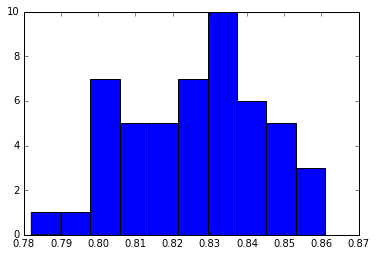

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(accuracies1);